In [ ]:
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt

# Bootstrapping

We draw observations from a data sample one at a time. After each sampling step is completed, we place the observation back to the data sample. This procedure is called *sampling with replacement*. The non-parametric bootstrap algorithm looks like this:

---
Pseudo algorithm

---
<ol>
<li> Choose the size (n) for the bootstrapped dataset</li>
<li> while i <= B do</li>
<ul>
<li>Sample with replacement n observations, i.e. $\{x_i^b\}_{i=1}^n$</li>
<li> Use $\{x_i^b\}$ and calculate your estimate $\hat{\theta}_b^*$ </li>
</ul>
<li> Now you have $\{\hat{\theta}_b^*\}_{b=1}^B=\hat{\theta}_1^*,\hat{\theta}_2^*,\cdots,\hat{\theta}_B^*$. </li>
</ol>

---

  

## Bootstrap regression coefficient $\beta$

Assume the true $\beta=0.5$  is the true parameter in the linear model $y=\beta x_1 +ϵ$. 

Let's simulate some data and compare the (**unbiased**) OLS estimate $\beta_{OLS}$ with the bootstrap estimate $\hat{\beta} \equiv \hat{\theta}^*$.

In [ ]:
# The true regression parameters
b1 = 0.5
# The sample size for the original dataset
N = 100
# The number of bootstrap simulations
B = 10000

# Generate x
x = 2 + np.random.normal(0,1,N)
# Generate the random errors
e = 5*np.random.normal(0,1,N)
# Generate y
y = b1*x + e

# fit a linear regression and obtain the parameter estimate
ols_model = sm.OLS(y,x).fit()
b1_ols = ols_model.params[0]
# theoretical 95% confidence interval (bse is the standard error for the 
# coefficients)
asym_95 = [b1_ols - 1.96*ols_model.bse[0], b1_ols + 1.96*ols_model.bse[0]]
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.040
Model:                            OLS   Adj. R-squared (uncentered):              0.030
Method:                 Least Squares   F-statistic:                              4.074
Date:                Mon, 07 Feb 2022   Prob (F-statistic):                      0.0463
Time:                        19:15:36   Log-Likelihood:                         -301.26
No. Observations:                 100   AIC:                                      604.5
Df Residuals:                      99   BIC:                                      607.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Now bootstrap code

In [ ]:
# list to save the bootstrapped b_1 values
b1_bootstrapped=[]
for b in range(B):    
    # sampling (only an index) with replacement
    indx_boot = np.random.choice(x.shape[0], size=N)
    
    # use the index to sample (with replacement) x and y
    yb   = y[indx_boot]    
    xb   = x[indx_boot]
    
    # expand the dimension to get a matrix of sixe N x 1
    # so we can use matrix maltiplication later on
    xb = xb[:,None]
    yb = yb[:,None]

    # get OSL estimate via matrix formula (X'X)^(-1)X'y
    b1_b = np.dot(np.linalg.inv(np.dot(xb.T,xb)),np.dot(xb.T,yb))[0][0]

    # append estimate
    b1_bootstrapped.append(b1_b)


## Confidence intervals for $\beta$
The list `b1_bootstrapped` contains the bootstrap data set $\{\hat{\theta}_b^*\}_{b=1}^B$.

Assuming that
\begin{equation}
\hat{\theta}_b^* \sim N(\beta_{OLS}, \hat{s.e.}^2)
\end{equation}

we can estimate 95% confidence intervals using
\begin{equation}
{\beta}_{OLS}  \pm 1.96*s.e.(\hat{\beta}^*),
\end{equation}
where 
\begin{equation}
s.e.(\hat{\beta}) \approx \sqrt{\frac{1}{B-1} \sum_{b=1}^B (\hat{\beta}_b^*  - \beta_{OLS})^2}
\end{equation}

In [ ]:
se_b1 = np.sqrt(np.sum((b1_bootstrapped - b1_ols)**2)/(B-1))
bootstr_95 = [b1_ols - 1.96*se_b1, b1_ols + 1.96*se_b1]
print(bootstr_95)


[0.0871541537895878, 0.831608893019178]


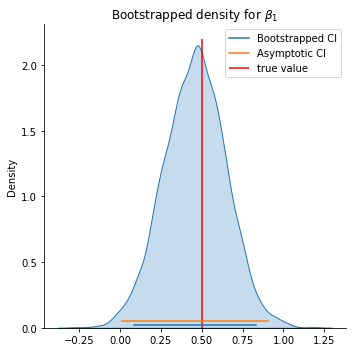

In [ ]:
sns.displot(b1_bootstrapped,kind='kde',fill=True)
plt.vlines(x=b1,ymin=0,ymax=2.2,colors='r',label='true value')
plt.plot(bootstr_95,[0.02,0.02],label='Bootstrapped CI')
plt.plot(asym_95,[0.05,0.05],label='Asymptotic CI')
plt.legend()
plt.title(r'Bootstrapped density for $\beta_1$')
plt.tight_layout()
plt.savefig('bootstrap_1.pdf')
plt.show()

## What is the uncertainty on the distribution for $\exp(\beta)$?
Getting the uncertainty from non-linear transformations on parameters can be impossible using the standard confidence
intervals. However, given simulated values from a Bootstrap, one can easily do the transformations and compute the correct confidence intervals/se. Hence, we can do this: 

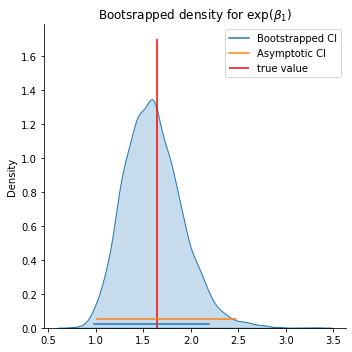

In [ ]:
se_b1_exp = np.sqrt(np.sum((np.exp(b1_bootstrapped) - np.exp(b1_ols))**2/(B-1)))
b_95_b1_exp_int = [np.exp(b1_ols)- 1.96*se_b1_exp, np.exp(b1_ols) + 1.96*se_b1_exp]

sns.displot(np.exp(b1_bootstrapped),kind='kde',fill=True)
plt.vlines(x=np.exp(b1),ymin=0,ymax=1.7,colors='r',label='true value')
plt.plot(b_95_b1_exp_int,[0.02,0.02],label='Bootstrapped CI')
plt.plot(np.exp(asym_95),[0.05,0.05],label='Asymptotic CI')
plt.title(r'Bootsrapped density for $\exp(\beta_1)$')
plt.legend()
plt.tight_layout()
plt.savefig('bootstrap_2.pdf')
plt.show()